# Frangieh2021 [not used yet for the paper]

In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy.sparse as sps

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:
os.chdir('./../')
os.getcwd()

'/mnt/home/icb/kemal.inecik/work/codes/multicpa-reproducibility'

In [5]:
%load_ext autoreload
%autoreload 2 

## Download

The preprocessed data files can be donloaded here: https://singlecell.broadinstitute.org/single_cell/study/SCP1064/multi-modal-pooled-perturb-cite-seq-screens-in-patient-models-define-novel-mechanisms-of-cancer-immune-evasion.

Paper: https://www.nature.com/articles/s41588-021-00779-1

## Transform csv to h5ad

transform the csv files to anndata h5df files

In [ ]:
fname = 'RNA_expression'
raw_data_dir = "/storage/groups/ml01/workspace/kemal.inecik/Frangieh2021/"
input_file_name = os.path.join(raw_data_dir, f'{fname}.csv')

In [ ]:
sp_data = []
gene_names = []
sep = ","

with open(input_file_name) as csv_file:
    first_line = True
    
    for row in csv_file:
        split_row = row.split(sep)
        
        if first_line:
            header_row = split_row[1:]
            first_line = False
            continue

        gene_names.append(split_row[0])
        gene_vals = np.array(split_row[1:]).astype(np.float32)
        gene_vals = sps.coo_matrix(gene_vals)
        sp_data.append(gene_vals)
                
sp_data = sps.vstack(sp_data)
sp_data = sp_data.transpose()
sp_data

In [ ]:
final_var = pd.DataFrame(gene_names).rename(columns={0: 'Gene'}).reset_index(drop=True)
final_var

In [ ]:
final_obs = pd.DataFrame(header_row).rename(columns={0: 'cell_ID'}).reset_index(drop=True)
final_obs

In [ ]:
sp_data = csr_matrix(sp_data.A)

In [ ]:
adata = ad.AnnData( X=sp_data, var=final_var, obs=final_obs)
adata

In [ ]:
adata.write(os.path.join(raw_data_dir, f'{fname}.h5ad'))

#### Merge gene and metadata

In [ ]:
fname = 'RNA_expression'
raw_data_dir = "/storage/groups/ml01/workspace/kemal.inecik/Frangieh2021/"
adata = sc.read(os.path.join(raw_data_dir, f'{fname}.h5ad'))

In [ ]:
adata.var = adata.var.set_index('Gene')
metadata = pd.read_csv(os.path.join(raw_data_dir, 'RNA_metadata.csv'))
metadata = metadata.drop(metadata.index[0]).reset_index(drop=True)
metadata = metadata.rename(columns={'NAME': 'cell_ID'}).set_index('cell_ID')
adata.obs = metadata

In [ ]:
print(np.unique(adata.obs["library_preparation_protocol"]))
del adata.obs["library_preparation_protocol"]

In [ ]:
adata.obs["UMI_count"] = adata.obs["UMI_count"].astype(float)
adata.obs["MOI"] = adata.obs["MOI"].astype(float)
assert np.all(adata.obs["UMI_count"].astype(np.uint32) == adata.obs["UMI_count"])
assert np.all(adata.obs["MOI"].astype(np.uint32) == adata.obs["MOI"])
adata.obs["MOI"] = adata.obs["MOI"].astype(int)
adata.obs["UMI_count"] = adata.obs["UMI_count"].astype(int)

- Paper: 

    Data on scRNA-seq counts waere normalized to 1,000,000 total counts per cell (transcripts per million), followed by a natural log transformation. 

- Email:

    The “RNA_metadata.csv” on the Broad Single Cell Portal file has the UMI counts for each cell (in the field labelled “UMI_count”). The normalization was log(CPM+1) where CPM stands for counts per million (each cell normalized to 1 million total counts). The UMI count by cell should allow you to reverse this transformation to obtain unnormalized UMI counts per cell


In [ ]:
def to_count(ind):
    m = adata.X[ind].A[0]
    umi = adata.obs.iloc[ind]["UMI_count"] 
    scale = umi / 1e6
    return (scale * (np.exp(m) - 1)).astype(int).astype(float)

In [ ]:
sp_data = []
for i in range(adata.X.shape[0]):
    gene_vals = to_count(i)
    gene_vals = sps.coo_matrix(gene_vals)
    sp_data.append(gene_vals)
sp_data = sps.vstack(sp_data)
sp_data = csr_matrix(sp_data.A)
adata.layers["counts"] = sp_data

#### Merge protein data

- Paper: protein normalized data and count data are used as it is.

    CITE-seq data were normalized according to the formula: 
    
    `max(np.log((a+1) / (c+1)), 0)`
    
    
    where a is UMI count for antibody a and c is UMI count for its corresponding IgG control c.

In [ ]:
protein_data = pd.read_csv(os.path.join(raw_data_dir, 'raw_CITE_expression.csv'))
protein_data = protein_data.set_index('Unnamed: 0').T
protein_data = protein_data.drop(columns=['Rat_IgG2a', 'Mouse_IgG1', 'Mouse_IgG2a', 'Mouse_IgG2b'])
protein_data.columns.name = "Protein"
protein_data.index.name = "cell_ID"

In [ ]:
print(len(protein_data.index))
print(len(adata.obs.index))

In [ ]:
keep_cells = np.array([i for i in adata.obs.index if i in protein_data.index])
adata = adata[keep_cells, :]
protein_data = protein_data.loc[keep_cells]

In [ ]:
protein_data_norm = pd.read_csv(os.path.join(raw_data_dir, 'Protein_expression.csv'))
protein_data_norm = protein_data_norm.set_index('Protein').T

In [ ]:
protein_data_norm.columns.name = "Protein"
protein_data_norm.index.name = "cell_ID"
protein_data_norm = protein_data_norm.loc[keep_cells]

In [ ]:
replace_col = {i: i.split()[0] for i in protein_data_norm.columns}
col_order = list(replace_col.values())
protein_data_norm.rename(columns=replace_col,  errors='raise', inplace=True)

In [ ]:
protein_data = protein_data[col_order]
protein_data_norm = protein_data_norm[col_order]

In [ ]:
protein_names = np.array(col_order)
protein_data = protein_data.to_numpy()
protein_data_norm = protein_data_norm.to_numpy()

In [ ]:
adata.uns['protein_names'] = protein_names
adata.obsm['protein_expression_raw'] = protein_data
adata.obsm['protein_expression'] = protein_data_norm

In [ ]:
adata.write(os.path.join(raw_data_dir, f'Frangieh22_prep_init.h5ad'))

## Manage Perturbations

In [6]:
raw_data_dir = "/storage/groups/ml01/workspace/kemal.inecik/Frangieh2021/"
adata = sc.read(os.path.join(raw_data_dir, 'Frangieh22_prep_init.h5ad'))

<AxesSubplot:xlabel='MOI', ylabel='Count'>

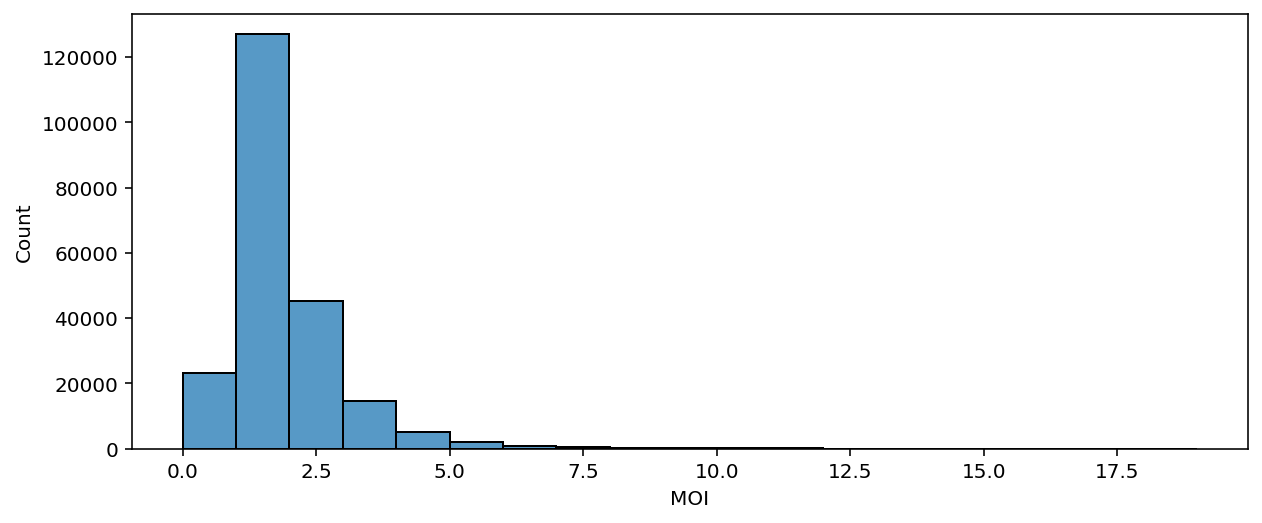

In [13]:
plt.figure(figsize=(10, 4))
sns.histplot(adata.obs["MOI"], bins=19)

cultured the cells for 14 days and then co-cultured them with a range of TIL doses (1:1, 2:1 or 4:1), treated them with IFN-γ (no co-culture) or maintained them in culture medium alone (control).

In [7]:
print(np.unique(adata.obs['condition']))

['Co-culture' 'Control' 'IFNγ']


In [14]:
adata.obs['cell_type'] = adata.obs['condition'].replace({'Co-culture': 'coculture', 'Control': 'control', 'IFNγ': 'ifngamma'})
del adata.obs["condition"]

In [16]:
allsgrna = pd.read_csv(os.path.join(raw_data_dir, 'all_sgRNA_assignments.txt'))
allsgrna = allsgrna.set_index('Cell')
allsgrna.index.name = "cell_ID"
allsgrna = allsgrna.loc[adata.obs.index]
allsgrna["sgRNAs"] = allsgrna["sgRNAs"].str.split(',')
allsgrna["sgRNAs"] = [i if isinstance(i, list) else ["NT_"] for i in allsgrna["sgRNAs"].to_list()]
allsgrna["sgRNAs"] = [[j if not j.startswith("ONE_NON-GENE_SITE_") else "NT_" for j in i] for i in allsgrna["sgRNAs"]]
allsgrna["sgRNAs"] = [[j if not j.startswith("NO_SITE_") else "NT_'" for j in i] for i in allsgrna["sgRNAs"]]
allsgrna["sgRNAs"] = [sorted(set([j.split('_')[0] for j in i])) for i in allsgrna["sgRNAs"]]
# bring NT last place
allsgrna["sgRNAs"] = [i if "NT" not in i else [j for j in i if j!="NT"]+["NT"]  for i in allsgrna["sgRNAs"]]

In [17]:
allsgrna["len_sgRNAs"] = [len(i) for i in allsgrna["sgRNAs"]]
allsgrna["guide_merged"] = ["+".join(i) for i in allsgrna["sgRNAs"]]
def doses(i): return '+'.join(['1']*i)
allsgrna['dose_val'] = [doses(i) for i in allsgrna["len_sgRNAs"]]
allsgrna

,sgRNAs,len_sgRNAs,guide_merged,dose_val
cell_ID,,,,
CELL_1,[HLA-B],1,HLA-B,1
CELL_2,"[NGFR, SERPINF1]",2,NGFR+SERPINF1,1+1
CELL_3,[HLA-B],1,HLA-B,1
CELL_4,"[NMRK1, S100A6]",2,NMRK1+S100A6,1+1
CELL_5,[NT],1,NT,1
...,...,...,...,...
CELL_218327,"[CTSO, PIK3IP1, VDAC2, WNT7A]",4,CTSO+PIK3IP1+VDAC2+WNT7A,1+1+1+1
CELL_218328,"[JAK2, SLC7A5P1]",2,JAK2+SLC7A5P1,1+1
CELL_218329,"[S100A6, SAT1, NT]",3,S100A6+SAT1+NT,1+1+1


In [18]:
adata.obs["condition"] = allsgrna["guide_merged"]
adata.obs['dose_val'] = allsgrna['dose_val']
adata.obs

,MOI,sgRNA,UMI_count,cell_type,condition,dose_val
cell_ID,,,,,,
CELL_1,1,HLA-B_2,10832,control,HLA-B,1
CELL_2,2,NaN,10731,control,NGFR+SERPINF1,1+1
CELL_3,1,HLA-B_2,28821,control,HLA-B,1
CELL_4,2,NaN,15322,control,NMRK1+S100A6,1+1
CELL_5,0,NaN,10314,control,NT,1
...,...,...,...,...,...,...
CELL_218327,4,NaN,12722,coculture,CTSO+PIK3IP1+VDAC2+WNT7A,1+1+1+1
CELL_218328,2,NaN,11643,coculture,JAK2+SLC7A5P1,1+1
CELL_218329,3,NaN,12497,coculture,S100A6+SAT1+NT,1+1+1


## Preprocess data

In [18]:
# As normalized data is obtained from rds
    # sc.pp.normalize_total(adata) 
    # sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:15)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [19]:
a=adata.var.copy()
a=a.sort_values(by=["dispersions_norm"])

for ind, i in enumerate(a['highly_variable']):
    if i:
        break
ind

20024

In [20]:
len(a)

23712

In [21]:
print(sum(a["highly_variable"]))

2550


In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:14)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
adata.X.max()

12.946405

In [24]:
adata.obsm['protein_expression'].max()

12.204148

In [25]:
adata

AnnData object with n_obs × n_vars = 218328 × 5000
    obs: 'MOI', 'sgRNA', 'UMI_count', 'cell_type', 'condition', 'dose_val'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'protein_names', 'hvg'
    obsm: 'protein_expression', 'protein_expression_raw'
    layers: 'counts'

## Prepare for the model

In [26]:
adata.obs['control'] = [1 if x == 'NT' else 0 for x in adata.obs.condition.values]
adata.obs['drug_dose_name'] = adata.obs.condition.astype(str) + '_' + adata.obs.dose_val.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)

In [27]:
adata.obs.groupby('cell_type').size()

cell_type
coculture    73114
control      57624
infgamma     87590
dtype: int64

In [ ]:
adata.obs.groupby('cov_drug_dose_name').size()

In [128]:
cddn = pd.DataFrame(adata.obs.groupby('cov_drug_dose_name').size(), columns=['cell_count']).reset_index()
cddn

,cov_drug_dose_name,cell_count
0,coculture_A2M+A2M+UCN2_1+1+1,1
1,coculture_A2M+AGA+RNF213+SOX4_1+1+1+1,1
2,coculture_A2M+AGA+SDCBP+TYR_1+1+1+1,1
3,coculture_A2M+AGA_1+1,1
4,coculture_A2M+APOC2_1+1,1
...,...,...
49895,infgamma_XAGE1A+NUP50-AS1+ONE-NON-GENE-SITE_1+1+1,1
49896,infgamma_XAGE1A+NUP50-AS1_1+1,1
49897,infgamma_XAGE1A+ONE-NON-GENE-SITE+NO-SITE_1+1+1,2
49898,infgamma_XAGE1A+ONE-NON-GENE-SITE_1+1,8


In [131]:
cddn[cddn['cell_count']>30]['cov_drug_dose_name']

187        coculture_A2M_1
270      coculture_ACSL3_1
451      coculture_ACTA2_1
592      coculture_AEBP1_1
750        coculture_AGA_1
               ...        
49871      infgamma_VAT1_1
49876     infgamma_VDAC2_1
49884      infgamma_WBP2_1
49891     infgamma_WNT7A_1
49899    infgamma_XAGE1A_1
Name: cov_drug_dose_name, Length: 697, dtype: object

In [33]:
adata.obs

,MOI,sgRNA,UMI_count,cell_type,condition,dose_val,control,drug_dose_name,cov_drug_dose_name
cell_ID,,,,,,,,,
CELL_1,1,HLA-B_2,10832,control,HLA-B,1,0,HLA-B_1,control_HLA-B_1
CELL_2,2,NaN,10731,control,NGFR+SERPINF1,1+1,0,NGFR+SERPINF1_1+1,control_NGFR+SERPINF1_1+1
CELL_3,1,HLA-B_2,28821,control,HLA-B,1,0,HLA-B_1,control_HLA-B_1
CELL_4,2,NaN,15322,control,NMRK1+S100A6,1+1,0,NMRK1+S100A6_1+1,control_NMRK1+S100A6_1+1
CELL_5,0,NaN,10314,control,NT,1,1,NT_1,control_NT_1
...,...,...,...,...,...,...,...,...,...
CELL_218327,4,NaN,12722,coculture,CTSO+PIK3IP1+VDAC2+WNT7A,1+1+1+1,0,CTSO+PIK3IP1+VDAC2+WNT7A_1+1+1+1,coculture_CTSO+PIK3IP1+VDAC2+WNT7A_1+1+1+1
CELL_218328,2,NaN,11643,coculture,JAK2+SLC7A5P1,1+1,0,JAK2+SLC7A5P1_1+1,coculture_JAK2+SLC7A5P1_1+1
CELL_218329,3,NaN,12497,coculture,S100A6+SAT1+NT,1+1+1,0,S100A6+SAT1+NT_1+1+1,coculture_S100A6+SAT1+NT_1+1+1


<function abs(x, /)>

In [117]:
# 1) bunlar gercekten hucre covariate mi
# 2) tek basina kalan hucreyi ne yapmali???? onun diff expressed 20 genini bulmak..
#        gerek yok cunku hesaplarda 30'dan cok olunca hucre sayisi calciulate ediyor

In [30]:
adata.obs[adata.obs["cov_drug_dose_name"] == "coculture_NT_1"]

,MOI,sgRNA,UMI_count,cell_type,condition,dose_val,control,drug_dose_name,cov_drug_dose_name
cell_ID,,,,,,,,,
CELL_145221,0,NaN,8038,coculture,NT,1,1,NT_1,coculture_NT_1
CELL_145229,0,NaN,35509,coculture,NT,1,1,NT_1,coculture_NT_1
CELL_145234,1,NO_SITE_23,14867,coculture,NT,1,1,NT_1,coculture_NT_1
CELL_145238,0,NaN,20190,coculture,NT,1,1,NT_1,coculture_NT_1
CELL_145239,0,NaN,13703,coculture,NT,1,1,NT_1,coculture_NT_1
...,...,...,...,...,...,...,...,...,...
CELL_218309,1,NO_SITE_628,10457,coculture,NT,1,1,NT_1,coculture_NT_1
CELL_218315,0,NaN,4376,coculture,NT,1,1,NT_1,coculture_NT_1
CELL_218318,0,NaN,11104,coculture,NT,1,1,NT_1,coculture_NT_1


In [73]:
m=adata[adata.obs["cov_drug_dose_name"] == "control_APOD+TM4SF1_1+1"]

In [74]:
from MultiCPA.helper import rank_genes_groups_by_cov
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', pd.errors.PerformanceWarning)
    rank_genes_groups_by_cov(m, 
                             groupby='cov_drug_dose_name', covariate='cell_type', control_group='NT_1', n_genes=20)

control
ranking genes


AttributeError: Can only use .cat accessor with a 'category' dtype

In [69]:
adata.obs

,MOI,sgRNA,UMI_count,cell_type,condition,dose_val,control,drug_dose_name,cov_drug_dose_name
cell_ID,,,,,,,,,
CELL_1,1,HLA-B_2,10832,control,HLA-B,1,0,HLA-B_1,control_HLA-B_1
CELL_2,2,NaN,10731,control,NGFR+SERPINF1,1+1,0,NGFR+SERPINF1_1+1,control_NGFR+SERPINF1_1+1
CELL_3,1,HLA-B_2,28821,control,HLA-B,1,0,HLA-B_1,control_HLA-B_1
CELL_4,2,NaN,15322,control,NMRK1+S100A6,1+1,0,NMRK1+S100A6_1+1,control_NMRK1+S100A6_1+1
CELL_5,0,NaN,10314,control,NT,1,1,NT_1,control_NT_1
...,...,...,...,...,...,...,...,...,...
CELL_218327,4,NaN,12722,coculture,CTSO+PIK3IP1+VDAC2+WNT7A,1+1+1+1,0,CTSO+PIK3IP1+VDAC2+WNT7A_1+1+1+1,coculture_CTSO+PIK3IP1+VDAC2+WNT7A_1+1+1+1
CELL_218328,2,NaN,11643,coculture,JAK2+SLC7A5P1,1+1,0,JAK2+SLC7A5P1_1+1,coculture_JAK2+SLC7A5P1_1+1
CELL_218329,3,NaN,12497,coculture,S100A6+SAT1+ONE-NON-GENE-SITE,1+1+1,0,S100A6+SAT1+ONE-NON-GENE-SITE_1+1+1,coculture_S100A6+SAT1+ONE-NON-GENE-SITE_1+1+1
